In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.array as da
import anndata
import scanpy as sc
import matplotlib.pyplot as plt

import yaml
from os.path import join

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [2]:
PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [3]:
ddf = dd.read_parquet(join(PATH, 'train'), split_row_groups=True)
cell_type_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/cell_type.parquet'))
tech_sample_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/tech_sample.parquet'))

In [4]:
def get_count_matrix_and_obs(ddf):
    obs = ddf[['cell_type', 'tech_sample', 'assay', 'dataset_id', 'tissue']].compute()
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    obs = ddf[['cell_type', 'tech_sample', 'assay', 'dataset_id', 'tissue']].compute()

    return x, obs

In [5]:
x, obs = get_count_matrix_and_obs(ddf)

In [6]:
x

dask.array<values, shape=(15240192, 19331), dtype=float32, chunksize=(1024, 19331), chunktype=numpy.ndarray>

# Visualize augmented data

## Compute augmentations

In [7]:
augmentations = np.load(join(PATH, 'augmentations.npy'))


def augment(x, augmentations, seed=1):
    rng = np.random.default_rng(seed=seed)
    
    augmentations = augmentations[
        rng.integers(0, augmentations.shape[0], (x.shape[0], )), :
    ]
    sign = rng.choice([-1., 1.], (x.shape[0], 1))

    return np.clip(x + (sign * augmentations), a_min=0., a_max=9.)


In [8]:
# sub_sample x
x_subset = x[:300_000, :].compute()  # data is already shuffled -> just take first x cells
obs_subset = obs.iloc[:300_000]

In [9]:
# subset to 50 top cell types to not break the color scale of the plots
mask = obs_subset.cell_type.isin(obs_subset.cell_type.value_counts().head(50).index.tolist()).to_numpy()
x_subset = x_subset[mask, :]
obs_subset = obs_subset.iloc[mask, :]

In [10]:
x_subset_augment = augment(x_subset, augmentations)

In [11]:
adata = anndata.AnnData(
    X=x_subset, 
    obs=pd.DataFrame({
        'cell_type': cell_type_mapping.iloc[obs_subset['cell_type'].to_numpy()].to_numpy().flatten(),
        'tech_sample': tech_sample_mapping.iloc[obs_subset['tech_sample'].to_numpy()].to_numpy().flatten()
    })
)

adata_augment = anndata.AnnData(
    X=x_subset_augment, 
    obs=pd.DataFrame({
        'cell_type': cell_type_mapping.iloc[obs_subset['cell_type'].to_numpy()].to_numpy().flatten(),
        'tech_sample': tech_sample_mapping.iloc[obs_subset['tech_sample'].to_numpy()].to_numpy().flatten()
    })
)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
with open('shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

In [13]:
adata.obs['cell_type'] = adata.obs['cell_type'].replace(shortend_cell_types)
adata_augment.obs['cell_type'] = adata_augment.obs['cell_type'].replace(shortend_cell_types)

In [14]:
sc.pp.pca(adata)
sc.tl.tsne(adata)
sc.pp.pca(adata_augment)
sc.tl.tsne(adata_augment)

In [15]:
from scipy.sparse import csr_matrix


adata.X = csr_matrix(adata.X)
adata_augment.X = csr_matrix(adata_augment.X)

In [16]:
adata.write_h5ad('/mnt/dssfs02/tmp/adata.h5ad')
adata_augment.write_h5ad('/mnt/dssfs02/tmp/adata_augment.h5ad')

## Visualize augmentations

In [7]:
adata = sc.read_h5ad('/mnt/dssfs02/tmp/adata.h5ad')
adata_augment = sc.read_h5ad('/mnt/dssfs02/tmp/adata_augment.h5ad')

In [8]:
sc.settings.figdir = '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure3/'

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


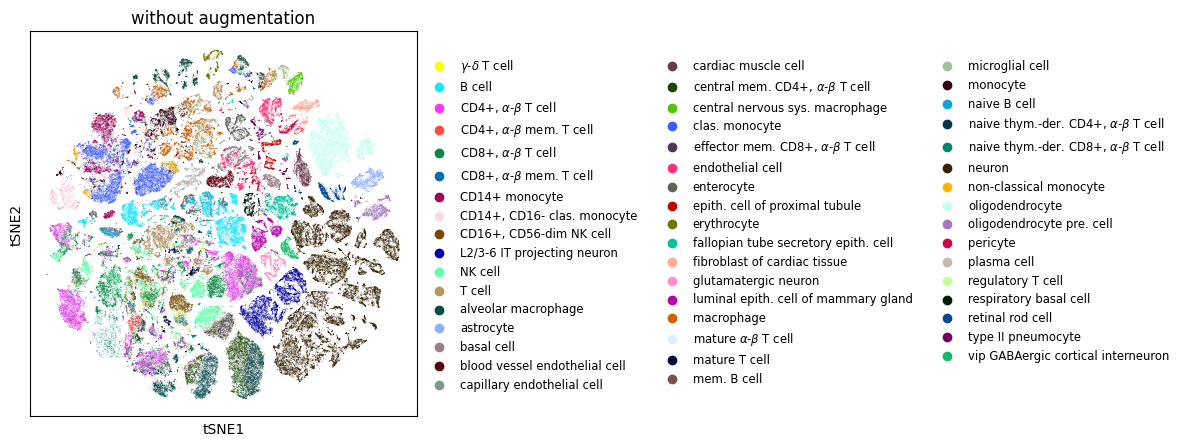

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sc.pl.tsne(
    adata, 
    color='cell_type', 
    title='without augmentation', 
    legend_fontsize='small', 
    ax=ax,
    show=True,
    save='_no_augentation.pdf'
)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


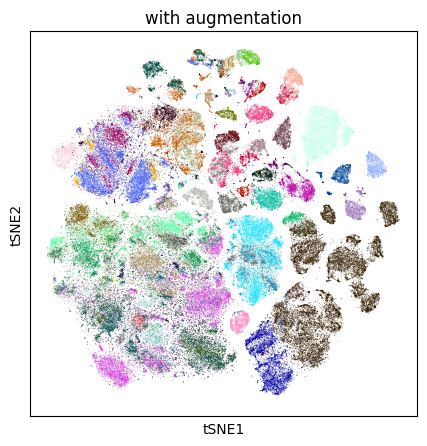

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sc.pl.tsne(adata_augment, color='cell_type', title='with augmentation', legend_fontsize='x-small', ax=ax, show=False)
ax.get_legend().remove()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure3/tsne_with_augmentation.pdf')

In [ ]:
# save images as high resolution png image

In [ ]:
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250 # If 'figure', uses the figure's dpi value.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sc.pl.tsne(
    adata, 
    color='cell_type', 
    title='without augmentation', 
    legend_fontsize='x-small', 
    ax=ax,
    save='_no_augmentation.png'
)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sc.pl.tsne(adata_augment, color='cell_type', title='with augmentation', legend_fontsize='xx-small', ax=ax, show=False)
ax.get_legend().remove()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure3/tsne_with_augmentation.png', dpi=250)

## Explained variance by cell type 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix

In [3]:
adata = sc.read_h5ad('/mnt/dssfs02/tmp/adata.h5ad')
adata_augment = sc.read_h5ad('/mnt/dssfs02/tmp/adata_augment.h5ad')

In [11]:
enc = OneHotEncoder()
x_celltype = enc.fit_transform(adata.obs.cell_type.to_numpy().reshape((-1, 1))).toarray()
x_techsample = enc.fit_transform(adata.obs.tech_sample.to_numpy().reshape((-1, 1))).toarray()
x = csr_matrix(np.concatenate([x_celltype, x_techsample], axis=1))

y = adata.X.toarray()
y_augment = adata_augment.X.toarray()

In [33]:
regressor_augment = LinearRegression(n_jobs=-1).fit(x, y_augment)
score_augment = regressor_augment.score(x, y_augment)
f'R^2: {score_augment:.3f}'

'R^2: 0.164'

In [34]:
regressor = LinearRegression(n_jobs=-1).fit(x, y)
score = regressor.score(x, y)
f'R^2: {score:.3f}'

'R^2: 0.189'